# Модель предсказания заказов такси в аэропортах
**Проект №11 Яндекс.Практикум - Data Science**

## Описание проекта

**Исходные данные:**

Исторические данные по количеству заказов такси.

**Цель проекта:**

Разработать модель предсказывающая количество заказов такси в аэропортах, чтобы привлекать больше водителей в период пиковой нагрузки.

**Условия задачи:**

Спрогнозировать количество заказов такси на следующий час.

Данные необходимо
1. Проанализирать.
2. Обучите разные модели с различными гиперпараметрами.
3. Получить на тестовой выборке значение **RMSE** не более **48**.

### Структура проекта
* [1. Загрузка и подготовка данных](#start)
* [2. Анализ данных](#eda)
* [3. Обучение модели и подбор гиперпараметров](#model)
* [4. Тестирование](#testing)
* [5. Общий вывод](#conclusion)

<a id="start"></a>
## 1. Загрузка и подготовка данных

#### Импортируем необходимые библиотеки

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.model_selection import TimeSeriesSplit

#### Загрузим данные в DataFrame

In [2]:
dataset = 'taxi.csv'

try:
    data = pd.read_csv(f'../datasets/{dataset}', sep=',')
    print(f'Прочитан файл с данными: "./datasets/{dataset}"')
except:
    try:
        data = pd.read_csv(f'/datasets/{dataset}', sep=',') # yandex.praktikum
        print(f'Прочитан файл с данными: "/datasets/{dataset}"')
    except Exception as err:
        print(repr(err))

Прочитан файл с данными: "./datasets/taxi.csv"


In [3]:
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


В исходном датасете 26496 записей с количеством заказов на каждый 10минутный интервал времени. Пропуски в данных отсутствуют.

Приведём признак datetime к типу datetime

In [5]:
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d %H:%M:%S')

Выполним ресемплинг данных на 1 часовой интервал и установим время как индекс для удобства обработки.

In [6]:
data = data.set_index('datetime').resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


#### Вывод:
* загрузили данные и не обнаружили пропуски;
* выполнили ресемплинг на 1 часовой интервал.

<a id="eda"></a>
## 2. Анализ данных

Проанализируем какой у нас интервал данных

In [7]:
print(f'Start of period: {data.index.min()}')
print(f'End of period:   {data.index.max()}')

Start of period: 2018-03-01 00:00:00
End of period:   2018-08-31 23:00:00


Построим график количества заказов

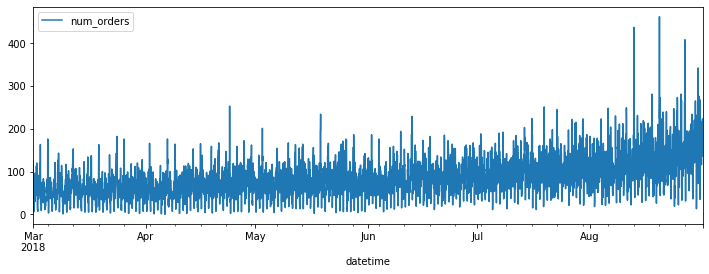

In [8]:
FIGSIZE = (12,4)
data.plot(figsize=FIGSIZE)

Проверим есть ли циклично повторяющиеся закономерности в измненении кол-ва заказов

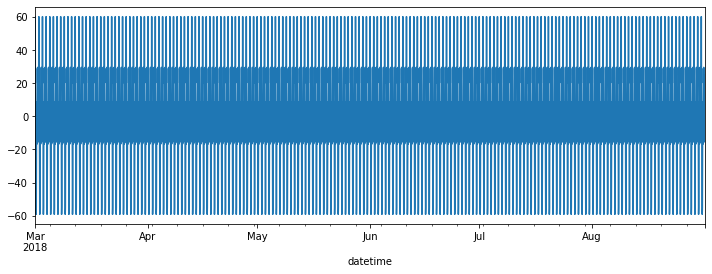

In [9]:
decomposed = seasonal_decompose(data)
decomposed.seasonal.plot(figsize=FIGSIZE)

Сезонность имеет очень маленький период, поэтому постоим для меньшего интервала времени (одна неделя)

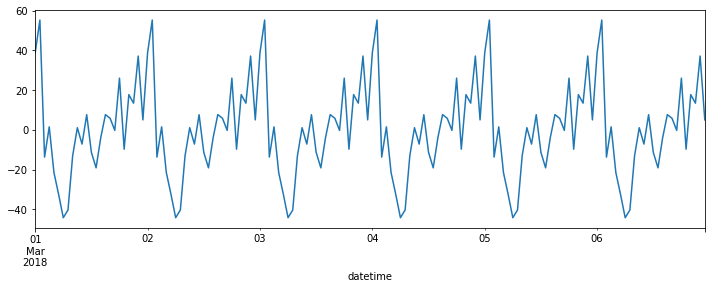

In [10]:
seasonal_decompose(data['2018-03-01':'2018-03-6']).seasonal.plot(figsize=FIGSIZE)

Наблюдаем проявление сезонности ежедневно: больше всего заказов к концу дня, а меньше всего ночью

Проверим проявляется ли тренд за выбранный период

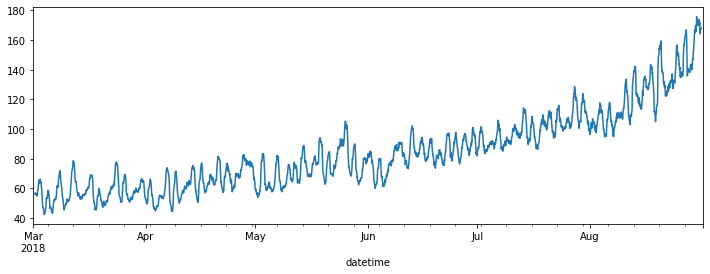

In [11]:
decomposed.trend.plot(figsize=FIGSIZE)

Наблюдаем плавное увеличение кол-ва заказов с конца весны, но конца лета

Построим график изменения кол-ва заказов очищенный от сезонности и тренда

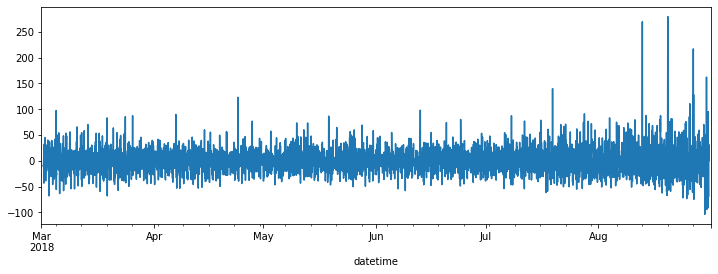

In [12]:
decomposed.resid.plot(figsize=FIGSIZE)

Можем отметить, что волатильность изменений кол-ва заказов к концу периода (конец лета) выше.

<a id="model"></a>
## 3. Обучение модели и подбор гиперпараметров

Создадим функцию которая создаст дополнительные параметры

In [13]:
def make_features(data, max_lag, rolling):
    data['day'] = data.index.day
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
 
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(2*lag)
 
    for i, roll in zip(range(len(rolling)), rolling):
        data['rolling_mean_{}'.format(i)] = data['num_orders'].shift().rolling(roll).mean()

Добавим признаки отстающих значений и скользящее среднее

In [14]:
rolling = [5, 13]
make_features(data, 8, rolling)

Разделим датасет на обучающую и тестовую выборку в соотношении 9:1

In [15]:
features_train, features_test, target_train, target_test = train_test_split(
    data.drop(['num_orders'], axis=1), data['num_orders'], test_size=0.1, shuffle=False, random_state=91) 

Подберём гиперпараметры для CatBoostRegressor

In [16]:
tscv = TimeSeriesSplit(n_splits=3) # corectly split time series data

model = CatBoostRegressor(loss_function='RMSE',
                          verbose=100,
                          thread_count=-1,
                          random_seed=91)

grid = {'depth': [4, 5, 6],
        'min_data_in_leaf':[3, 4, 5],
        'l2_leaf_reg': [3, 5, 9, 11, 13]
       }

grid_search_result = model.grid_search(grid,
                                       cv=tscv,
                                       X=features_train, 
                                       y=target_train,
                                       plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 31.27864347
bestIteration = 876

0:	loss: 31.2786435	best: 31.2786435 (0)	total: 2.09s	remaining: 1m 32s

bestTest = 31.63856132
bestIteration = 996

1:	loss: 31.6385613	best: 31.2786435 (0)	total: 4.08s	remaining: 1m 27s

bestTest = 31.71715773
bestIteration = 990

2:	loss: 31.7171577	best: 31.2786435 (0)	total: 6.02s	remaining: 1m 24s

bestTest = 31.9088274
bestIteration = 999

3:	loss: 31.9088274	best: 31.2786435 (0)	total: 8.1s	remaining: 1m 23s

bestTest = 31.95748389
bestIteration = 979

4:	loss: 31.9574839	best: 31.2786435 (0)	total: 9.93s	remaining: 1m 19s

bestTest = 31.62637734
bestIteration = 701

5:	loss: 31.6263773	best: 31.2786435 (0)	total: 12.2s	remaining: 1m 19s

bestTest = 31.76027923
bestIteration = 780

6:	loss: 31.7602792	best: 31.2786435 (0)	total: 14.4s	remaining: 1m 18s

bestTest = 32.06542341
bestIteration = 900

7:	loss: 32.0654234	best: 31.2786435 (0)	total: 16.9s	remaining: 1m 17s

bestTest = 32.37303589
bestIteration = 976

8:	loss: 32.3730359	b

In [17]:
print(f"Best CatBoost params: {grid_search_result['params']}")

Best CatBoost params: {'min_data_in_leaf': 3, 'depth': 4, 'l2_leaf_reg': 3}


Обучим модель линейной регрессии

In [18]:
reg = LinearRegression().fit(features_train.dropna(), target_train[features_train.dropna().index]) # losing part of data

#### Вывод:
* Добавили дополнительные признаки: день, час, день недели, скользящее среднее и отстающие значения.
* В качестве модели применили CatBoost Regressor и подобрали наилучшие гиперпараметры.

<a id="testing"></a>
## 4. Тестирование

In [19]:
predicted_reg = reg.predict(features_test)
predicted_catboost = model.predict(features_test)

print(f'RMSE Linear:   {mean_squared_error(target_test, predicted_reg, squared=False)}')
print(f'RMSE Catboost: {mean_squared_error(target_test, predicted_catboost, squared=False)}')

RMSE Linear:   56.76201417265607
RMSE Catboost: 43.21119197767762


<a id="conclusion"></a>
## 5. Общий вывод

* Был проведён анализ данных в ходе которого была выявлена цикличность кол-ва заказов и тренд на увеличение кол-ва заказов. 
* Добавили дополнительные признаки: день, час, день недели, скользящее среднее и отстающие значения.
* В качестве модели была использована модель градиентного бустинга библиотек.
* С помощью кросс валидации были подобраны наилучшие параметры для CatBoostRegressor.
* Получили итоговое RMSE на тестовых данных 46.49.